In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [7]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

print(train.shape, test.shape)
train.head(5)

(15035, 21) (6468, 20)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 데이터 전처리

In [8]:
# x, y 분리
y = train["price"]
train.drop("price", axis=1, inplace=True)
train

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

id, zipcode는 제거하자

In [9]:
# 필요없는 데이터 제거
train.drop(["id", "zipcode"], axis=1, inplace=True)
test.drop(["id", "zipcode"], axis=1, inplace=True)

# date 의미없는 숫자 날리기
train["date"] = train["date"].apply(lambda x : x[:6]).astype(int)
test["date"] = test["date"].apply(lambda x : x[:6]).astype(int)

train.head(3)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
1,201502,2,1.0,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
2,201502,3,2.0,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503


In [10]:
# 결측치 확인
train.isnull().sum()

date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [8]:
test.isnull().sum()

date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

결측치 없고 깰끔하네요~

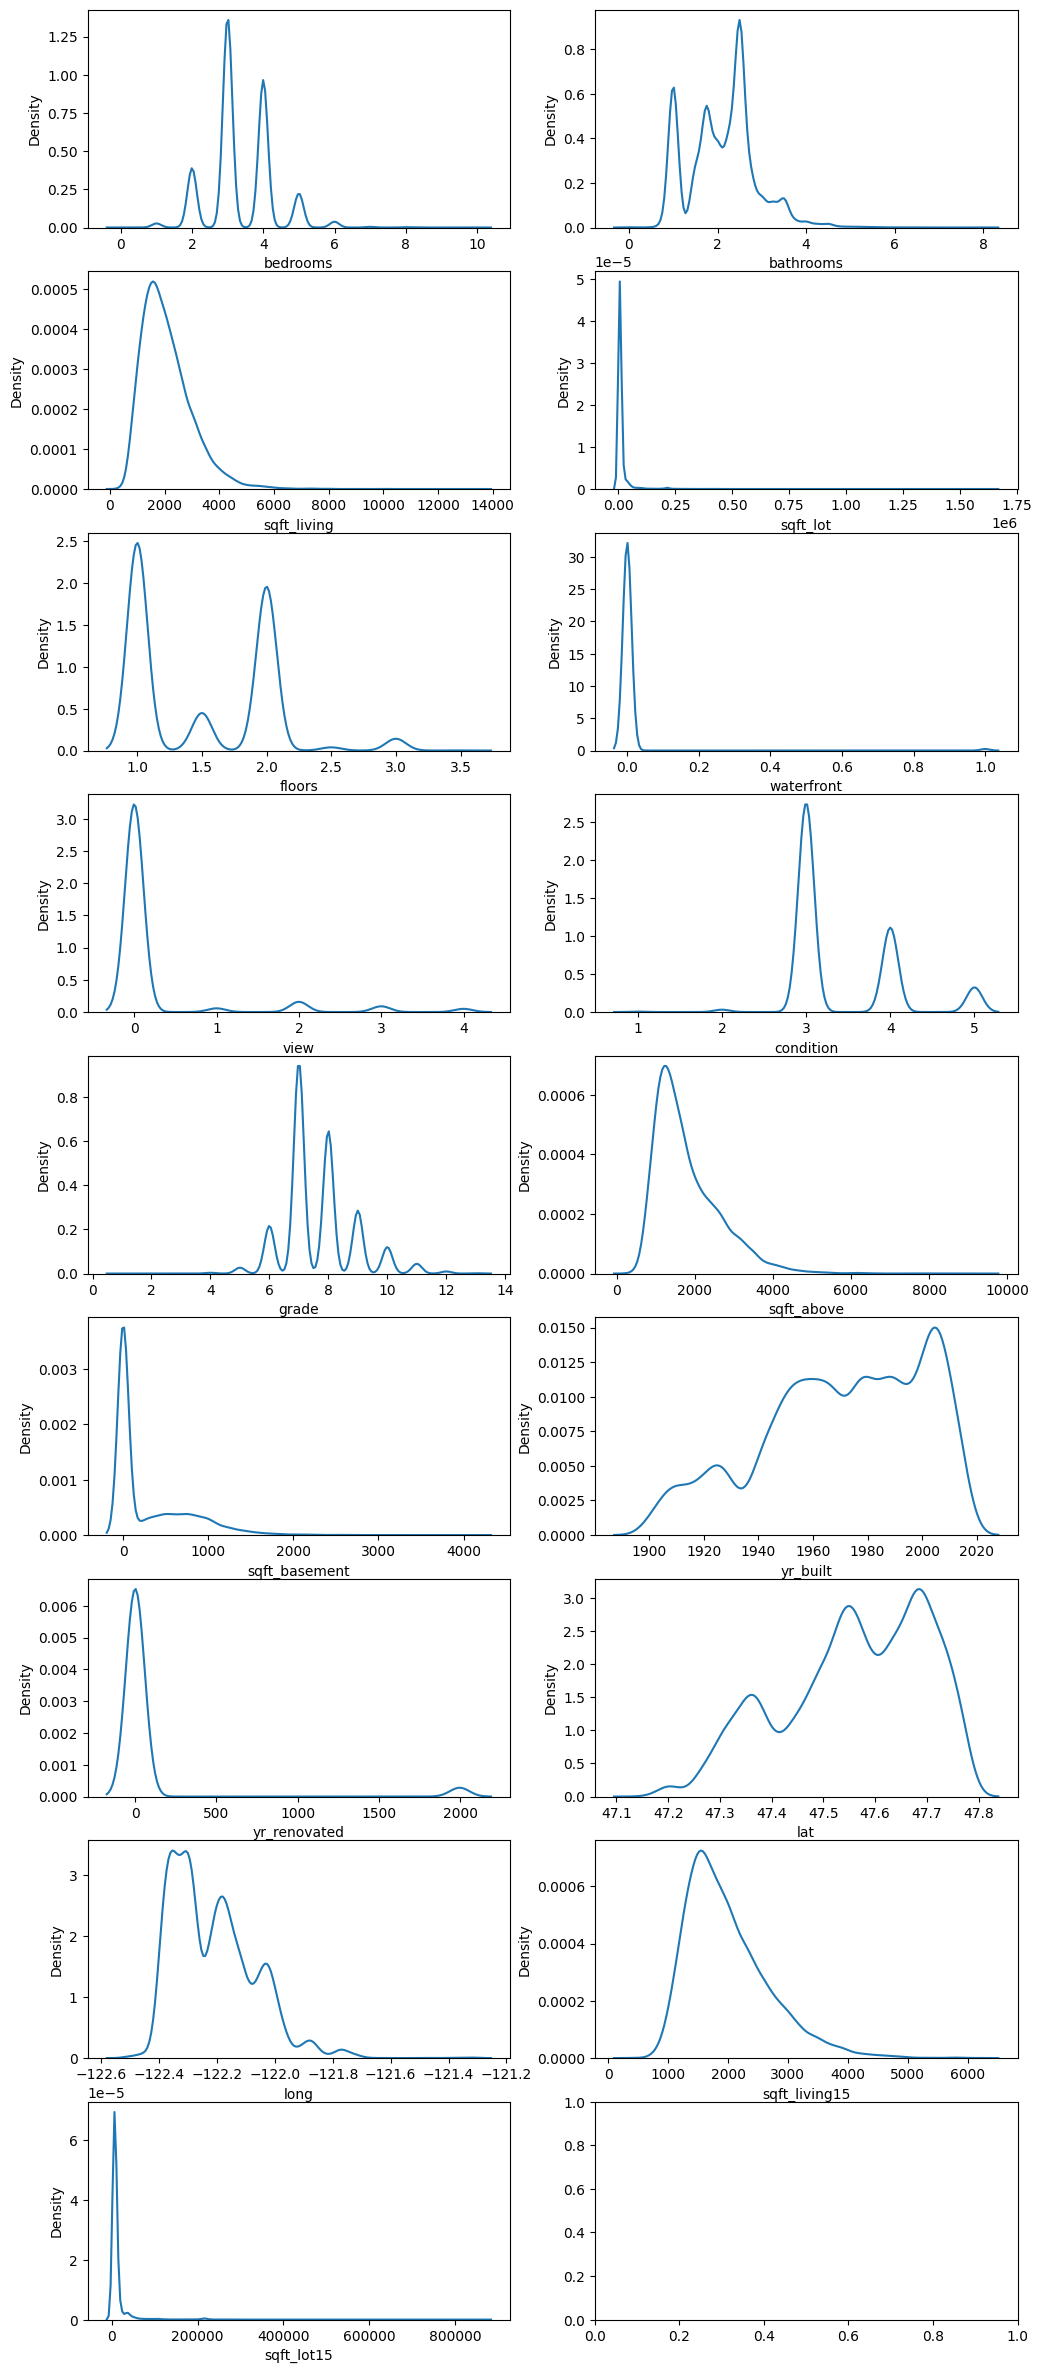

In [11]:
fig, ax = plt.subplots(9, 2, figsize=(12, 30))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        if row == 8 and col == 1:
            break
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        # ax[row][col].set_title(columns[count], fontsize=13)
        count += 1
        if count == 11 :
            break

In [13]:
# train, test x log스케일 변환
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']
for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

train

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0,47.5112,-122.257,7.201171,8.639588
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0,47.7379,-122.233,7.908755,8.995041
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0,47.6168,-122.045,7.496097,8.923191
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,0,47.3097,-122.327,7.713785,8.827615
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,0,47.4095,-122.315,7.409136,9.181118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,1.609438,2.50,7.832411,8.703507,2.0,0,0,3,9,7.832411,0.000000,2014,0,47.5137,-122.167,7.832411,8.703507
15031,201503,1.609438,3.50,8.163656,8.881975,2.0,0,0,3,9,7.863651,6.814543,2009,0,47.5537,-122.398,7.626083,8.732466
15032,201405,1.386294,2.50,7.333676,7.031741,3.0,0,0,3,8,7.333676,0.000000,2009,0,47.6993,-122.346,7.333676,7.319865
15033,201502,1.609438,2.50,7.745436,8.668024,2.0,0,0,3,8,7.745436,0.000000,2014,0,47.5107,-122.362,7.512618,8.881975


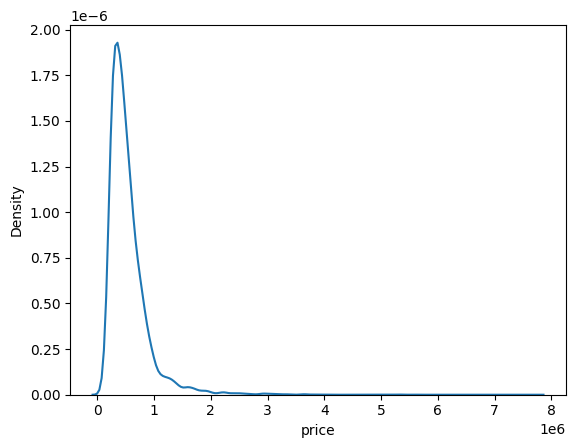

In [14]:
# y값도 수정해주자
sns.kdeplot(y)
plt.show()

In [15]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

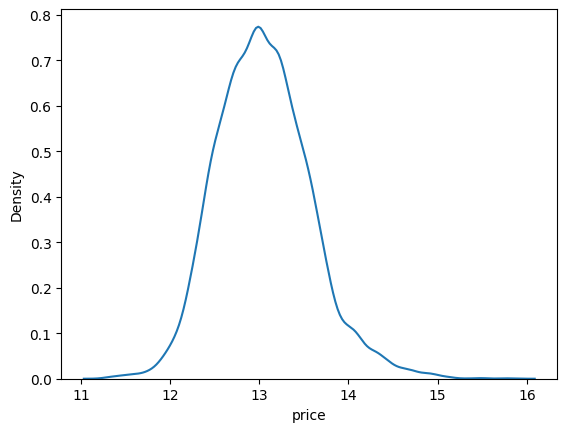

In [16]:
sns.kdeplot(y)
plt.show()

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int32  
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  lat            15035 non-null  float64
 15  long           15035 non-null  float64
 16  sqft_living15  15035 non-null  float64
 17  sqft_lot15     15035 non-null  float64
dtypes: flo

In [ ]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [24]:
train.shape, y.shape

((15035, 18), (15035,))

In [45]:
from sklearn.model_selection import GridSearchCV

random_state = 333

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7]
}

param_grid_lgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

# 모델과 하이퍼파라미터 그리드 설정
models = [
    (GradientBoostingRegressor(random_state=random_state), param_grid_gb),
    # 버전 관련문제로 오류
    # (XGBRegressor(random_state=random_state), param_grid_xgb),
    (LGBMRegressor(random_state=random_state), param_grid_lgb),
    (RandomForestRegressor(random_state=random_state), param_grid_rf)
]


data = {}
for model, param_grid in models:
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=5)
    grid_model.fit(train, y)
    params = grid_model.cv_results_["params"]
    score = grid_model.cv_results_["mean_test_score"]
    print(params, score)
    params.append(score)
    data[model] = params
    

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}, {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}, {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}, {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}, {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}, {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}, {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}, {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}, {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}, {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}, {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}, {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}, {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}, {'learning_rate'

In [53]:
model_name = list(data.keys())
model_name

[GradientBoostingRegressor(random_state=333),
 LGBMRegressor(random_state=333),
 RandomForestRegressor(random_state=333)]

In [175]:
for i, model in enumerate(model_name):
    if i >= 1:
        set_value = data[model][:-1]
        score_value = data[model][-1]
        result = pd.DataFrame(set_value)
        result["score"] = score_value
        result["model"] = str(model)
        results = pd.concat([results, result])
    else:
        set_value = data[model][:-1]
        score_value = data[model][-1]
        results = pd.DataFrame(set_value)
        results["score"] = score_value
        results["model"] = str(model)

results.reset_index(drop=True, inplace=True)
results["model"].value_counts()

model
GradientBoostingRegressor(random_state=333)    27
LGBMRegressor(random_state=333)                27
RandomForestRegressor(random_state=333)         9
Name: count, dtype: int64

In [176]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,learning_rate,max_depth,n_estimators,score,model,RMSE
0,0.1,3,100,-0.034123,GradientBoostingRegressor(random_state=333),0.184725
1,0.1,3,200,-0.030226,GradientBoostingRegressor(random_state=333),0.173857
2,0.1,3,300,-0.029113,GradientBoostingRegressor(random_state=333),0.170626
3,0.1,5,100,-0.028737,GradientBoostingRegressor(random_state=333),0.169520
4,0.1,5,200,-0.027538,GradientBoostingRegressor(random_state=333),0.165946
...,...,...,...,...,...,...
58,NaN,5,200,-0.058367,RandomForestRegressor(random_state=333),0.241593
59,NaN,5,300,-0.058229,RandomForestRegressor(random_state=333),0.241306
60,NaN,7,100,-0.044392,RandomForestRegressor(random_state=333),0.210694
61,NaN,7,200,-0.044431,RandomForestRegressor(random_state=333),0.210787


In [177]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,learning_rate,max_depth,n_estimators,score,model,RMSLE
0,0.1,3,100,-0.034123,GradientBoostingRegressor(random_state=333),0.184725
1,0.1,3,200,-0.030226,GradientBoostingRegressor(random_state=333),0.173857
2,0.1,3,300,-0.029113,GradientBoostingRegressor(random_state=333),0.170626
3,0.1,5,100,-0.028737,GradientBoostingRegressor(random_state=333),0.169520
4,0.1,5,200,-0.027538,GradientBoostingRegressor(random_state=333),0.165946
...,...,...,...,...,...,...
58,NaN,5,200,-0.058367,RandomForestRegressor(random_state=333),0.241593
59,NaN,5,300,-0.058229,RandomForestRegressor(random_state=333),0.241306
60,NaN,7,100,-0.044392,RandomForestRegressor(random_state=333),0.210694
61,NaN,7,200,-0.044431,RandomForestRegressor(random_state=333),0.210787


In [179]:
results = results.sort_values('RMSLE')
results.head(5)

,learning_rate,max_depth,n_estimators,score,model,RMSLE
35,0.10,7,300,-0.026546,LGBMRegressor(random_state=333),0.162928
34,0.10,7,200,-0.026652,LGBMRegressor(random_state=333),0.163254
44,0.05,7,300,-0.026705,LGBMRegressor(random_state=333),0.163415
32,0.10,5,300,-0.026968,LGBMRegressor(random_state=333),0.164220
5,0.10,5,300,-0.027157,GradientBoostingRegressor(random_state=333),0.164794


결론을 얻었다.

In [181]:
model = LGBMRegressor(learning_rate=0.1, max_depth=7, n_estimators=300, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
y_pred = np.expm1(prediction)
y_pred

array([ 507022.12930424,  505946.55647229, 1377945.25247671, ...,
        475301.84682034,  315119.52359427,  438291.13870099])

In [182]:
submission = pd.read_csv("./data/sample_submission.csv")
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [183]:
submission["price"] = y_pred
submission.head()

,id,price
0,15035,5.070221e+05
1,15036,5.059466e+05
2,15037,1.377945e+06
3,15038,3.111774e+05
4,15039,3.260210e+05


In [184]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format("./data/", 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

./data//submission_lgbm_RMSLE_0.164399.csv


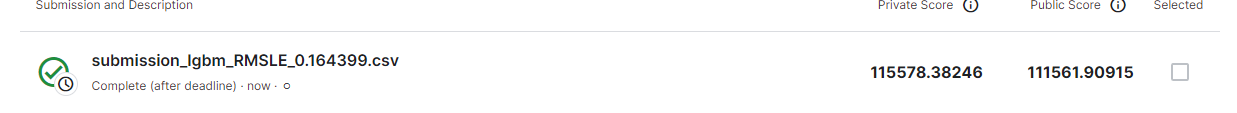